1. Подобрать таблицу данных с несбалансированными классами. Решить задачу классификации любым подходящим методом.


In [1]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

data, targets = make_classification(
    n_samples=20000,
    n_features=10,
    flip_y=0.03,
    n_classes=2,
    weights=[0.99]
)

train_data, test_data, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.2, random_state=42
)


model = GradientBoostingClassifier(n_estimators=20, max_depth=6, random_state=42, learning_rate=0.1)
model.fit(train_data, train_targets)


,loss,'log_loss'
,learning_rate,0.1
,n_estimators,20
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,6
,min_impurity_decrease,0.0
,init,None


2. Вычислить точность, полноту, специфичность.

In [2]:
from sklearn.metrics import confusion_matrix

preds = model.predict(test_data)
tn, fp, fn, tp = confusion_matrix(test_targets, preds).ravel()

specificity = tn / (tn + fp)
accuracy_score = (tp + tn) / (tp + tn + fp + fn)
recall_score = tp / (tp + fn)

print(f'Accuracy: {accuracy_score:.2f}')
print(f'Recall: {recall_score:.2f}')
print(f'Specificity: {specificity:.2f}')

Accuracy: 0.97
Recall: 0.27
Specificity: 0.99


3. Построить кривую ошибок и найти площадь под ней. Построить кривую "точность-полнота".

Text(0.5, 1.0, 'Precision-Recall curve')

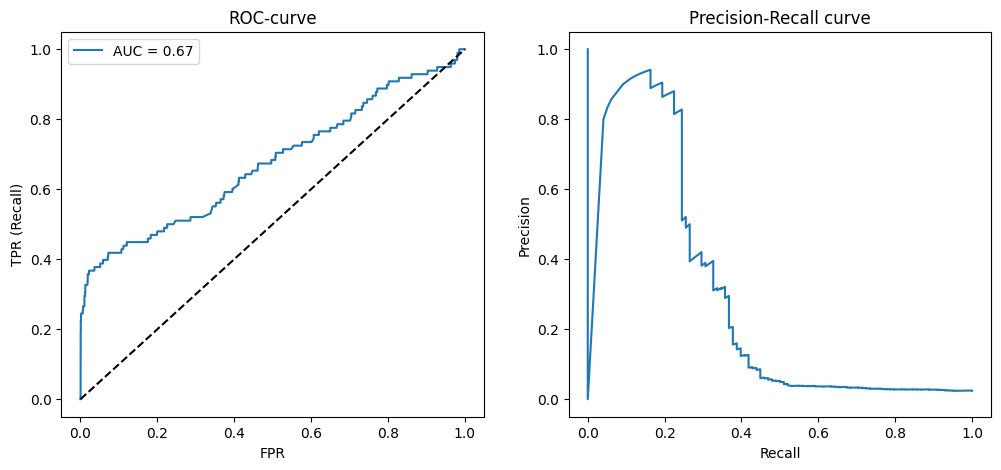

In [3]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

probs = model.predict_proba(test_data)[:, 1]

fpr, tpr, thresholds = roc_curve(test_targets, probs)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.title('ROC-curve')
plt.legend()


precision, recall, thresholds_pr = precision_recall_curve(test_targets, probs)

plt.subplot(1,2,2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')


4. Разбить данные на обучающую и контрольную выборки. Построить ROC- кривую для каждой из подвыборок. Построить ROC- кривую на основе кроссвалидации (объединить прогнозы для разных фолдов).

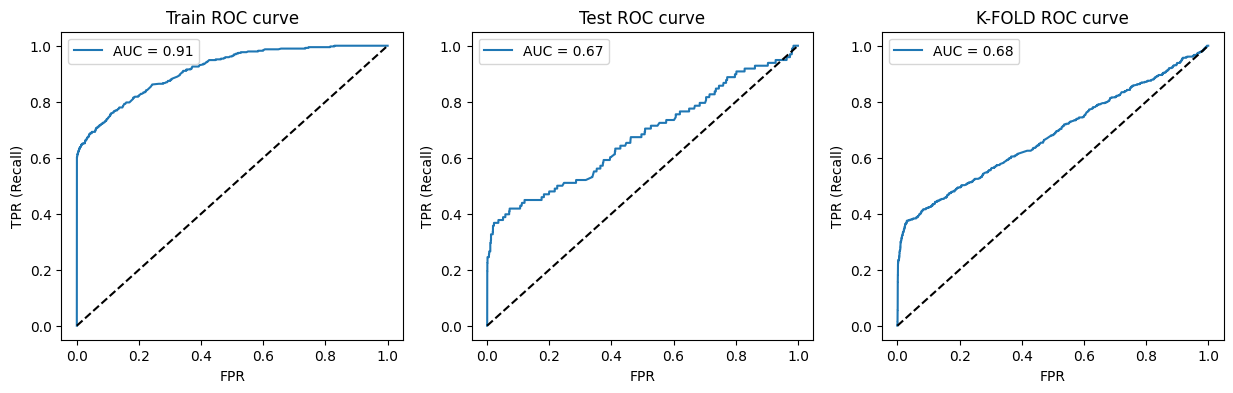

In [4]:
probs = model.predict_proba(train_data)[:, 1]
fpr, tpr, thresholds = roc_curve(train_targets, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.title('Train ROC curve')
plt.legend()

probs = model.predict_proba(test_data)[:, 1]
fpr, tpr, thresholds = roc_curve(test_targets, probs)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.title('Test ROC curve')
plt.legend()

from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)
y_true_all = []
y_probs_all = []

for train_idx, test_idx in kf.split(data, targets):
    X_train, X_val = data[train_idx], data[test_idx]
    y_train, y_val = targets[train_idx], targets[test_idx]
    
    model.fit(X_train, y_train)
    y_probs_all.extend(model.predict_proba(X_val)[:,1])
    y_true_all.extend(y_val)

fpr, tpr, _ = roc_curve(y_true_all, y_probs_all)
roc_auc = auc(fpr, tpr)


plt.subplot(1,3,3)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.title('K-FOLD ROC curve')
plt.legend()

5. Исследовать влияние выбора критерия обучения на AUC. Один из критериев — log loss, ещё один или два — на выбор. Как вариант: сравнить AdaBoost с градиентным бустингом.

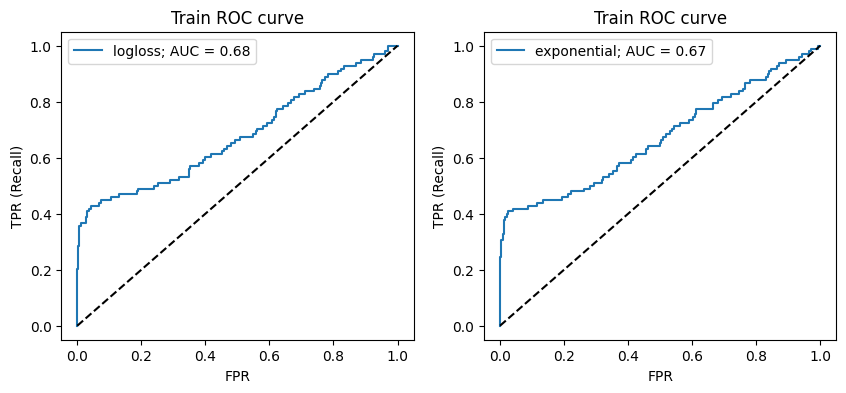

In [5]:
model = GradientBoostingClassifier(n_estimators=600, max_depth=6, random_state=42, learning_rate=0.01)
model.fit(train_data, train_targets)
probs_log_loss = model.predict_proba(test_data)[:, 1]

model = GradientBoostingClassifier(n_estimators=600, max_depth=6, random_state=42, learning_rate=0.01, loss="exponential")
model.fit(train_data, train_targets)
probs_exponential = model.predict_proba(test_data)[:, 1]



plt.figure(figsize=(10,4))


fpr, tpr, _ = roc_curve(test_targets, probs_log_loss)
roc_auc = auc(fpr, tpr)
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'logloss; AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.title('Train ROC curve')
plt.legend()

fpr, tpr, _ = roc_curve(test_targets, probs_exponential)
roc_auc = auc(fpr, tpr)
plt.subplot(1,2,2)
plt.plot(fpr, tpr, label=f'exponential; AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.title('Train ROC curve')
plt.legend()

6 (факультативно). Сбалансировать классы, используя веса для объектов выборки (подобрать веса так, чтобы суммарный вес каждого класса был одинаков). Решить задачу классификации (тем же методом, что и ранее), сравнить точность.

In [6]:
import numpy as np

class_counts = np.bincount(targets)
total = len(targets)

weights = total / (len(class_counts) * class_counts)

sample_weights = np.array([weights[i] for i in train_targets])

model = GradientBoostingClassifier(random_state=42)
model.fit(train_data, train_targets, sample_weight=sample_weights)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


Accuracy: 0.86
Recall: 0.88
Specificity: 0.57


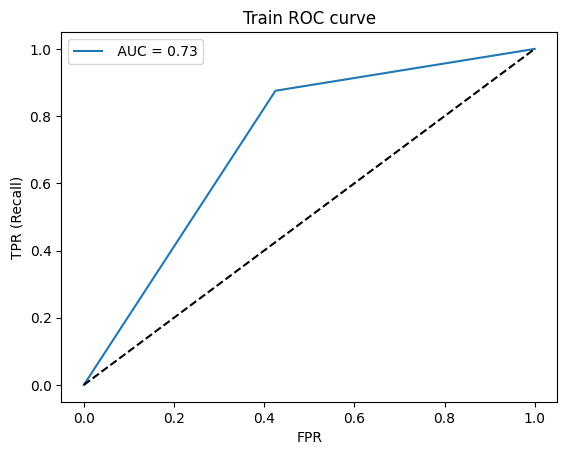

In [7]:
probs = model.predict(test_data)

preds = model.predict(test_data)
tn, fp, fn, tp = confusion_matrix(test_targets, preds).ravel()

specificity = tn / (tn + fp)
accuracy_score = (tp + tn) / (tp + tn + fp + fn)
recall_score = tp / (tp + fn)

print(f'Accuracy: {accuracy_score:.2f}')
print(f'Recall: {recall_score:.2f}')
print(f'Specificity: {specificity:.2f}')

fpr, tpr, _ = roc_curve(test_targets, probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f' AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.title('Train ROC curve')
plt.legend()